
## Pricing of Option on ZCBg.

---

## 1. Overview

The code simulates the evolution of short-term interest rates using the **Hull–White model**. This model is widely used in quantitative finance to price fixed income instruments and interest rate derivatives because it captures the mean-reverting behavior of interest rates. The key elements are:

- Simulation of the short rate process using an Euler discretization scheme.
- Calibration to the initial term structure via zero-coupon bond (ZCB) prices.
- Closed-form solutions for ZCB pricing and options on bonds.

---

## 2. Code Sections and Explanations

### 2.1 Preliminary Imports and `OptionType` Enum

- **Imports:**  
  The code imports libraries for numerical operations, plotting, integration, interpolation, and enumerations.  
- **`OptionType` Enum:**  
  ```python
  class OptionType(enum.Enum):
      CALL = 1.0
      PUT = -1.0
  ```  
  This defines two option types. The values are used later to distinguish between call and put options.

---

### 2.2 `GeneratePathsHWEuler(NoOfPaths, NoOfSteps, T, P0T, lambd, eta)`

**Purpose:**  
Simulate paths of the short rate, \$ r(t) \$, using the Euler discretization for the Hull–White model.

**Key Steps and Formulas:**

1. **Estimate the Instantaneous Forward Rate:**  
   ```python
   dt = 0.0001    
   f0T = lambda t: - (np.log(P0T(t+dt)) - np.log(P0T(t-dt))) / (2*dt)
   ```  
   **Formula:**  
   \$ f(0,t) \approx -\frac{\ln P(0,t+dt) - \ln P(0,t-dt)}{2\,dt} \$

2. **Initial Short Rate:**  
   ```python
   r0 = f0T(0.00001)
   ```  
   Here, \$ r(0) \approx f(0,t) \$ evaluated near \$ t=0 \$.

3. **Define the Drift Function \$ \theta(t) \$:**  
   ```python
   theta = lambda t: 1.0/lambd * (f0T(t+dt) - f0T(t-dt)) / (2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd) * (1.0 - np.exp(-2.0*lambd*t))
   ```  
   **Formula:**  
   \$ \theta(t) = \frac{1}{\lambda}\left(\frac{f(0,t+dt)-f(0,t-dt)}{2\,dt}\right) + f(0,t) + \frac{\eta^2}{2\lambda^2}\left(1-e^{-2\lambda t}\right) \$

4. **Simulate the Wiener Process \$ W(t) \$:**  
   The update step is:  
   \$ W(t+dt) = W(t) + \sqrt{dt}\,Z \$  
   where \$ Z \$ is a standard normal variable.

5. **Update the Short Rate \$ r(t) \$:**  
   The Euler discretization for the Hull–White SDE is:  
   \$ r(t+dt) = r(t) + \lambda\big(\theta(t)-r(t)\big)dt + \eta\,\Delta W \$

---

### 2.3 `HW_theta(lambd, eta, P0T)`

**Purpose:**  
Return the function \$ \theta(t) \$ for the Hull–White model, ensuring model calibration to the market data.

**Formula:**  
\$ \theta(t) = \frac{1}{\lambda}\left(\frac{f(0,t+dt)-f(0,t-dt)}{2\,dt}\right) + f(0,t) + \frac{\eta^2}{2\lambda^2}\left(1-e^{-2\lambda t}\right) \$

---

### 2.4 `HW_A(lambd, eta, P0T, T1, T2)`

**Purpose:**  
Compute the function \$ A(T_1,T_2) \$ used in the zero-coupon bond pricing formula.

**Steps and Formulas:**

- **Time Difference:**  
  \$ \tau = T_2 - T_1 \$

- **Definition of \$ B(\tau) \$:**  
  ```python
  B_r = lambda tau: 1.0/lambd * (np.exp(-lambd*tau)-1.0)
  ```  
  **Formula:**  
  \$ B(\tau) = \frac{e^{-\lambda\tau}-1}{\lambda} \$

- **Drift Adjustment (Integration Term):**  
  \$ \text{temp1} = \lambda \int_0^{\tau} \theta(T_2-z)\,B(z)\,dz \$

- **Volatility Adjustment Term:**  
  \$ \text{temp2} = \frac{\eta^2}{4\lambda^3}\Big(e^{-2\lambda\tau}\big(4e^{\lambda\tau}-1\big)-3\Big) + \frac{\eta^2\tau}{2\lambda^2} \$

- **Combine to Get \$ A \$:**  
  \$ A(T_1,T_2) = \text{temp1} + \text{temp2} \$

---

### 2.5 `HW_B(lambd, eta, T1, T2)`

**Purpose:**  
Compute the function \$ B(T_1,T_2) \$.

**Formula:**  
\$ B(T_1,T_2) = \frac{e^{-\lambda (T_2-T_1)}-1}{\lambda} \$

---

### 2.6 `HW_ZCB(lambd, eta, P0T, T1, T2, rT1)`

**Purpose:**  
Calculate the price of a zero-coupon bond (ZCB) at time \$ T_1 \$ with maturity \$ T_2 \$.

**Formula:**  
\$ P(T_1,T_2) = \exp\Big(A(T_1,T_2) + B(T_1,T_2)\,r(T_1)\Big) \$

---

### 2.7 `HWMean_r(P0T, lambd, eta, T)`

**Purpose:**  
Compute the expected mean of the short rate at time \$ T \$.

**Formula:**  
\$ \mathbb{E}[r(T)] = r_0\,e^{-\lambda T} + \lambda\int_0^T \theta(z)e^{-\lambda (T-z)}dz \$

---

### 2.8 `HW_r_0(P0T, lambd, eta)`

**Purpose:**  
Return the initial short rate \$ r_0 \$, estimated using the forward rate approximation.

---

### 2.9 `HW_Mu_FrwdMeasure(P0T, lambd, eta, T)`

**Purpose:**  
Calculate the mean of the short rate under the forward measure, which is used in option pricing.

**Key Component – Adjusted Drift:**  
\$ \theta_{\text{hat}}(t,T) = \theta(t) + \frac{\eta^2}{\lambda^2}\Big(e^{-\lambda(T-t)}-1\Big) \$

This adjustment modifies the drift to account for the change of measure from risk-neutral to forward.

---

### 2.10 `HWVar_r(lambd, eta, T)`

**Purpose:**  
Compute the variance of the short rate at time \$ T \$.

**Formula:**  
\$ \text{Var}[r(T)] = \frac{\eta^2}{2\lambda}\Big(1-e^{-2\lambda T}\Big) \$

---

### 2.11 `HWDensity(P0T, lambd, eta, T)`

**Purpose:**  
Return the probability density function (pdf) for \$ r(T) \$, assuming a normal distribution with mean \$ \mathbb{E}[r(T)] \$ and variance \$ \text{Var}[r(T)] \$.

**Expression:**  
\$ \text{pdf}(x) = \frac{1}{\sqrt{2\pi\,\text{Var}[r(T)]}}\exp\left(-\frac{(x-\mathbb{E}[r(T)])^2}{2\,\text{Var}[r(T)]}\right) \$

---

### 2.12 `HW_ZCB_CallPutPrice(CP, K, lambd, eta, P0T, T1, T2)`

**Purpose:**  
Compute the theoretical price of a call (or put) option on a zero-coupon bond.

**Steps and Formulas:**

1. **Calculate \$ A \$ and \$ B \$:**  
   \$ A = A(T_1,T_2) \quad \text{and} \quad B = B(T_1,T_2) \$

2. **Mean and Volatility Under Forward Measure:**  
   Let \$ \mu_r \$ be the mean and \$ v_r = \sqrt{\text{Var}[r(T_1)]} \$ be the volatility.

3. **Adjusted Strike:**  
   \$ \hat{K} = K\,\exp(-A) \$

4. **Standardization:**  
   Define:  
   \$ a = \frac{\ln(\hat{K})-B\,\mu_r}{B\,v_r}, \quad d_1 = a-B\,v_r, \quad d_2 = d_1+B\,v_r \$

5. **Option Price Formula:**  
   \$ \text{Price} = P(0,T_1)\exp(A)\Big[\exp\Big(\frac{1}{2}B^2v_r^2+B\,\mu_r\Big)\Phi(d_1)-\hat{K}\,\Phi(d_2)\Big] \$  
   For put options, an adjustment is made:  
   \$ \text{Put Price} = \text{Call Price} - P(0,T_2) + K\,P(0,T_1) \$

---

### 2.13 `mainCalculation()`

**Purpose:**  
Orchestrate the simulation and pricing experiments:

- **Simulation:**  
  Generate multiple short rate paths using the Euler scheme.
  
- **ZCB Pricing Comparison:**  
  Compare the analytical ZCB prices \$ P(0,T) \$ with model-based prices computed as:  
  \$ \text{Proxy} = \exp\Big(A+B\,r_0\Big) \$

- **Option Pricing Experiment:**  
  Calculate option values over a range of strikes using both Monte Carlo simulation and the theoretical pricing function.

- **Visualization:**  
  Generate plots to compare analytical and simulated prices.

---

## 3. Additional Insights for Quant Finance Interviews

- **Model Derivation:**  
  Understand the derivation of the Hull–White stochastic differential equation (SDE):  
  \$ dr(t) = \lambda\big(\theta(t)-r(t)\big)dt + \eta\,dW(t) \$

- **Numerical Methods:**  
  Be comfortable with the Euler discretization:  
  \$ r(t+dt) = r(t) + \lambda\big(\theta(t)-r(t)\big)dt + \eta\,\sqrt{dt}\,Z \$

- **Calibration and Implementation:**  
  Practice implementing the model in Python and calibrating it to market data using techniques like spline interpolation.

- **Economic Intuition:**  
  icing in financial institutions.

---

*Note:* If the LaTeX formulas are not displaying, ensure that you are in a Markdown cell in your Jupyter Notebook and not in a code cell. Also, check that MathJax is enabled in your notebook settings.
```

Swap price for K = 0 is 2835.619745580199
Swap price for K_par = 0.038080425275010696 is 0.0


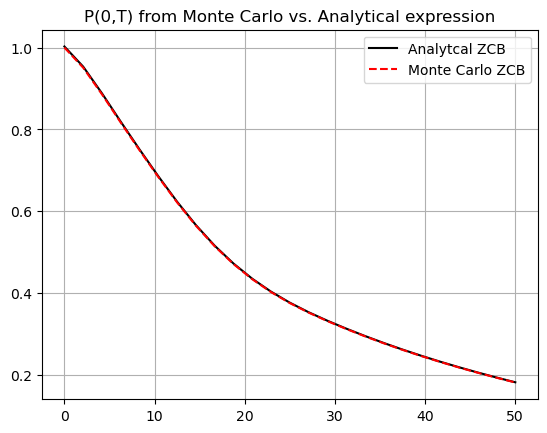

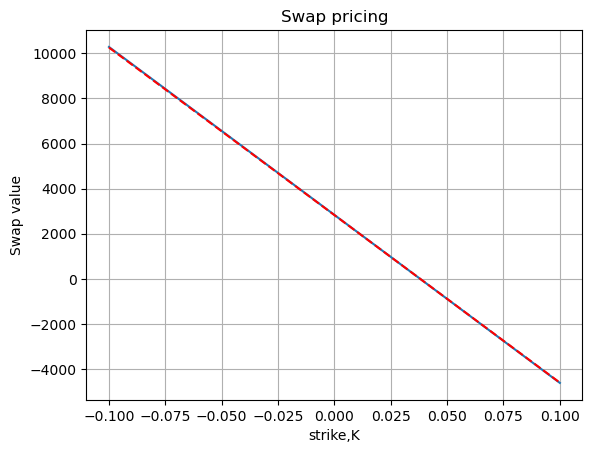

In [3]:

import numpy as np
import enum 
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy import interpolate
from scipy.optimize import newton

# This class defines puts and calls
class OptionTypeSwap(enum.Enum):
    RECEIVER = 1.0
    PAYER = -1.0

def GeneratePathsHWEuler(NoOfPaths,NoOfSteps,T,P0T, lambd, eta):    
    # time-step needed for differentiation
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))      
    
    #theta = lambda t: 0.1 +t -t
    #print("changed theta")
    
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
    R = np.zeros([NoOfPaths, NoOfSteps+1])
    R[:,0]=r0
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        R[:,i+1] = R[:,i] + lambd*(theta(time[i]) - R[:,i]) * dt + eta* (W[:,i+1]-W[:,i])
        time[i+1] = time[i] +dt
        
    # Outputs
    paths = {"time":time,"R":R}
    return paths

def HW_theta(lambd,eta,P0T):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    #print("CHANGED THETA")
    return theta#lambda t: 0.1+t-t
    
def HW_A(lambd,eta,P0T,T1,T2):
    tau = T2-T1
    zGrid = np.linspace(0.0,tau,250)
    B_r = lambda tau: 1.0/lambd * (np.exp(-lambd *tau)-1.0)
    theta = HW_theta(lambd,eta,P0T)    
    temp1 = lambd * integrate.trapz(theta(T2-zGrid)*B_r(zGrid),zGrid)
    
    temp2 = eta*eta/(4.0*np.power(lambd,3.0)) * (np.exp(-2.0*lambd*tau)*(4*np.exp(lambd*tau)-1.0) -3.0) + eta*eta*tau/(2.0*lambd*lambd)
    
    return temp1 + temp2

def HW_B(lambd,eta,T1,T2):
    return 1.0/lambd *(np.exp(-lambd*(T2-T1))-1.0)

def HW_ZCB(lambd,eta,P0T,T1,T2,rT1):
    n = np.size(rT1) 
        
    if T1<T2:
        B_r = HW_B(lambd,eta,T1,T2)
        A_r = HW_A(lambd,eta,P0T,T1,T2)
        return np.exp(A_r + B_r *rT1)
    else:
        return np.ones([n])

def HW_r_0(P0T,lambd,eta):
    # time-step needed for differentiation
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    return r0

def SwapPrice(CP,notional,K,t,Ti,Tm,n,P0T):
    # CP- payer of receiver
    # n- notional
    # K- strike
    # t- today's date
    # Ti- beginning of the swap
    # Tm- end of Swap
    # n- number of dates payments between Ti and Tm
    # r_t -interest rate at time t

    if n == 1:
        ti_grid =np.array([Ti,Tm])
    else:
        ti_grid = np.linspace(Ti,Tm,n)
    tau = ti_grid[1]- ti_grid[0]
    
    # overwrite Ti if t>Ti
    prevTi = ti_grid[np.where(ti_grid<t)]
    if np.size(prevTi) > 0: #prevTi != []:
        Ti = prevTi[-1]
    
    # Now we need to handle the case when some payments are already done
    ti_grid = ti_grid[np.where(ti_grid>t)]          

    temp= 0.0
    
    for (idx,ti) in enumerate(ti_grid):
        if ti>Ti:
            temp = temp + tau * P0T(ti)

    if CP==OptionTypeSwap.PAYER:
        swap = (P0T(Ti) - P0T(Tm)) - K * temp
    elif CP==OptionTypeSwap.RECEIVER:
        swap = K * temp- (P0T(Ti) - P0T(Tm))
    
    return swap*notional

def HW_SwapPrice(CP,notional,K,t,Ti,Tm,n,r_t,P0T,lambd,eta):
    # CP- payer of receiver
    # n- notional
    # K- strike
    # t- today's date
    # Ti- beginning of the swap
    # Tm- end of Swap
    # n- number of dates payments between Ti and Tm
    # r_t -interest rate at time t

    if n == 1:
        ti_grid =np.array([Ti,Tm])
    else:
        ti_grid = np.linspace(Ti,Tm,n)
    tau = ti_grid[1]- ti_grid[0]
    
    # overwrite Ti if t>Ti
    prevTi = ti_grid[np.where(ti_grid<t)]
    if np.size(prevTi) > 0: #prevTi != []:
        Ti = prevTi[-1]
    
    # Now we need to handle the case when some payments are already done
    ti_grid = ti_grid[np.where(ti_grid>t)]          

    temp= np.zeros(np.size(r_t));
    
    P_t_TiLambda = lambda Ti : HW_ZCB(lambd,eta,P0T,t,Ti,r_t)
    
    for (idx,ti) in enumerate(ti_grid):
        if ti>Ti:
            temp = temp + tau * P_t_TiLambda(ti)
            
    P_t_Ti = P_t_TiLambda(Ti)
    P_t_Tm = P_t_TiLambda(Tm)
    
    if CP==OptionTypeSwap.PAYER:
        swap = (P_t_Ti - P_t_Tm) - K * temp
    elif CP==OptionTypeSwap.RECEIVER:
        swap = K * temp- (P_t_Ti - P_t_Tm)
    
    return swap*notional

def mainCalculation():
    NoOfPaths = 2000
    NoOfSteps = 1000
    CP = OptionTypeSwap.PAYER
    lambd     = 0.5
    eta       = 0.03
    notional  = 10000.0 
    
    # We define a ZCB curve (obtained from the market), 1-D points with a B-spline curve.
    ti = [0.0,0.00273972600000000,0.0876712330000000,0.172602740000000,0.257534247000000,0.342465753000000,0.427397260000000,0.512328767000000,0.597260274000000,0.682191781000000,0.767123288000000,0.852054795000000,0.936986301000000,1.02191780800000,1.10684931500000,1.19178082200000,1.27671232900000,1.36164383600000,1.44657534200000,1.53150684900000,1.61643835600000,1.70136986300000,1.78630137000000,1.87123287700000,1.95616438400000,2.04109589000000,2.12602739700000,2.21095890400000,2.29589041100000,2.38082191800000,2.46575342500000,2.55068493200000,2.63561643800000,2.72054794500000,2.80547945200000,2.89041095900000,2.97534246600000,3.06027397300000,3.14520547900000,3.23013698600000,3.31506849300000,3.40000000000000,3.48493150700000,3.56986301400000,3.65479452100000,3.73972602700000,3.82465753400000,3.90958904100000,3.99452054800000,4.07945205500000,4.16438356200000,4.24931506800000,4.33424657500000,4.41917808200000,4.50410958900000,4.58904109600000,4.67397260300000,4.75890411000000,4.84383561600000,4.92876712300000,5.01369863000000,5.09863013700000,5.18356164400000,5.26849315100000,5.35342465800000,5.43835616400000,5.52328767100000,5.60821917800000,5.69315068500000,5.77808219200000,5.86301369900000,5.94794520500000,6.03287671200000,6.11780821900000,6.20273972600000,6.28767123300000,6.37260274000000,6.45753424700000,6.54246575300000,6.62739726000000,6.71232876700000,6.79726027400000,6.88219178100000,6.96712328800000,7.05205479500000,7.13698630100000,7.22191780800000,7.30684931500000,7.39178082200000,7.47671232900000,7.56164383600000,7.64657534200000,7.73150684900000,7.81643835600000,7.90136986300000,7.98630137000000,8.07123287700000,8.15616438400000,8.24109589000000,8.32602739700000,8.41095890400000,8.49589041100000,8.58082191800000,8.66575342500000,8.75068493200000,8.83561643800000,8.92054794500000,9.00547945200000,9.09041095900000,9.17534246600000,9.26027397300000,9.34520547900000,9.43013698600000,9.51506849300000,9.60000000000000,9.68493150700000,9.76986301400000,9.85479452100000,9.93972602700000,10.0246575300000,10.1095890400000,10.1945205500000,10.2794520500000,10.3643835600000,10.4493150700000,10.5342465800000,10.6191780800000,10.7041095900000,10.7890411000000,10.8739726000000,10.9589041100000,11.0438356200000,11.1287671200000,11.2136986300000,11.2986301400000,11.3835616400000,11.4684931500000,11.5534246600000,11.6383561600000,11.7232876700000,11.8082191800000,11.8931506800000,11.9780821900000,12.0630137000000,12.1479452100000,12.2328767100000,12.3178082200000,12.4027397300000,12.4876712300000,12.5726027400000,12.6575342500000,12.7424657500000,12.8273972600000,12.9123287700000,12.9972602700000,13.0821917800000,13.1671232900000,13.2520547900000,13.3369863000000,13.4219178100000,13.5068493200000,13.5917808200000,13.6767123300000,13.7616438400000,13.8465753400000,13.9315068500000,14.0164383600000,14.1013698600000,14.1863013700000,14.2712328800000,14.3561643800000,14.4410958900000,14.5260274000000,14.6109589000000,14.6958904100000,14.7808219200000,14.8657534200000,14.9506849300000,15.0356164400000,15.1205479500000,15.2054794500000,15.2904109600000,15.3753424700000,15.4602739700000,15.5452054800000,15.6301369900000,15.7150684900000,15.8000000000000,15.8849315100000,15.9698630100000,16.0547945200000,16.1397260300000,16.2246575300000,16.3095890400000,16.3945205500000,16.4794520500000,16.5643835600000,16.6493150700000,16.7342465800000,16.8191780800000,16.9041095900000,16.9890411000000,17.0739726000000,17.1589041100000,17.2438356200000,17.3287671200000,17.4136986300000,17.4986301400000,17.5835616400000,17.6684931500000,17.7534246600000,17.8383561600000,17.9232876700000,18.0082191800000,18.0931506800000,18.1780821900000,18.2630137000000,18.3479452100000,18.4328767100000,18.5178082200000,18.6027397300000,18.6876712300000,18.7726027400000,18.8575342500000,18.9424657500000,19.0273972600000,19.1123287700000,19.1972602700000,19.2821917800000,19.3671232900000,19.4520547900000,19.5369863000000,19.6219178100000,19.7068493200000,19.7917808200000,19.8767123300000,19.9616438400000,20.0465753400000,20.1315068500000,20.2164383600000,20.3013698600000,20.3863013700000,20.4712328800000,20.5561643800000,20.6410958900000,20.7260274000000,20.8109589000000,20.8958904100000,20.9808219200000,21.0657534200000,21.1506849300000,21.2356164400000,21.3205479500000,21.4054794500000,21.4904109600000,21.5753424700000,21.6602739700000,21.7452054800000,21.8301369900000,21.9150684900000,22,22.0849315100000,22.1698630100000,22.2547945200000,22.3397260300000,22.4246575300000,22.5095890400000,22.5945205500000,22.6794520500000,22.7643835600000,22.8493150700000,22.9342465800000,23.0191780800000,23.1041095900000,23.1890411000000,23.2739726000000,23.3589041100000,23.4438356200000,23.5287671200000,23.6136986300000,23.6986301400000,23.7835616400000,23.8684931500000,23.9534246600000,24.0383561600000,24.1232876700000,24.2082191800000,24.2931506800000,24.3780821900000,24.4630137000000,24.5479452100000,24.6328767100000,24.7178082200000,24.8027397300000,24.8876712300000,24.9726027400000,25.0575342500000,25.1424657500000,25.2273972600000,25.3123287700000,25.3972602700000,25.4821917800000,25.5671232900000,25.6520547900000,25.7369863000000,25.8219178100000,25.9068493200000,25.9917808200000,26.0767123300000,26.1616438400000,26.2465753400000,26.3315068500000,26.4164383600000,26.5013698600000,26.5863013700000,26.6712328800000,26.7561643800000,26.8410958900000,26.9260274000000,27.0109589000000,27.0958904100000,27.1808219200000,27.2657534200000,27.3506849300000,27.4356164400000,27.5205479500000,27.6054794500000,27.6904109600000,27.7753424700000,27.8602739700000,27.9452054800000,28.0301369900000,28.1150684900000,28.2000000000000,28.2849315100000,28.3698630100000,28.4547945200000,28.5397260300000,28.6246575300000,28.7095890400000,28.7945205500000,28.8794520500000,28.9643835600000,29.0493150700000,29.1342465800000,29.2191780800000,29.3041095900000,29.3890411000000,29.4739726000000,29.5589041100000,29.6438356200000,29.7287671200000,29.8136986300000,29.8986301400000,29.9835616400000,30.0684931500000,30.1534246600000,30.2383561600000,30.3232876700000,30.4082191800000,30.4931506800000,30.5780821900000,30.6630137000000,30.7479452100000,30.8328767100000,30.9178082200000,31.0027397300000,31.0876712300000,31.1726027400000,31.2575342500000,31.3424657500000,31.4273972600000,31.5123287700000,31.5972602700000,31.6821917800000,31.7671232900000,31.8520547900000,31.9369863000000,32.0219178100000,32.1068493200000,32.1917808200000,32.2767123300000,32.3616438400000,32.4465753400000,32.5315068500000,32.6164383600000,32.7013698600000,32.7863013700000,32.8712328800000,32.9561643800000,33.0410958900000,33.1260274000000,33.2109589000000,33.2958904100000,33.3808219200000,33.4657534200000,33.5506849300000,33.6356164400000,33.7205479500000,33.8054794500000,33.8904109600000,33.9753424700000,34.0602739700000,34.1452054800000,34.2301369900000,34.3150684900000,34.4000000000000,34.4849315100000,34.5698630100000,34.6547945200000,34.7397260300000,34.8246575300000,34.9095890400000,34.9945205500000,35.0794520500000,35.1643835600000,35.2493150700000,35.3342465800000,35.4191780800000,35.5041095900000,35.5890411000000,35.6739726000000,35.7589041100000,35.8438356200000,35.9287671200000,36.0136986300000,36.0986301400000,36.1835616400000,36.2684931500000,36.3534246600000,36.4383561600000,36.5232876700000,36.6082191800000,36.6931506800000,36.7780821900000,36.8630137000000,36.9479452100000,37.0328767100000,37.1178082200000,37.2027397300000,37.2876712300000,37.3726027400000,37.4575342500000,37.5424657500000,37.6273972600000,37.7123287700000,37.7972602700000,37.8821917800000,37.9671232900000,38.0520547900000,38.1369863000000,38.2219178100000,38.3068493200000,38.3917808200000,38.4767123300000,38.5616438400000,38.6465753400000,38.7315068500000,38.8164383600000,38.9013698600000,38.9863013700000,39.0712328800000,39.1561643800000,39.2410958900000,39.3260274000000,39.4109589000000,39.4958904100000,39.5808219200000,39.6657534200000,39.7506849300000,39.8356164400000,39.9205479500000,40.0054794500000]
    Pi = [1.0,0.999966573000000,0.998930882000000,0.997824062000000,0.996511145000000,0.995199956000000,0.993821602000000,0.992277014000000,0.990734827000000,0.989164324000000,0.987428762000000,0.985704346000000,0.983946708000000,0.982068207000000,0.980193293000000,0.978281187000000,0.976255832000000,0.974234670000000,0.972174514000000,0.970028236000000,0.967886697000000,0.965693800000000,0.963440984000000,0.961193424000000,0.958903753000000,0.956575247000000,0.954252397000000,0.951842433000000,0.949228406000000,0.946482248000000,0.943632525000000,0.940707509000000,0.937735160000000,0.934743101000000,0.931758611000000,0.928808623000000,0.925919731000000,0.923110403000000,0.920338655000000,0.917589739000000,0.914858924000000,0.912141532000000,0.909432941000000,0.906728583000000,0.904023944000000,0.901314567000000,0.898596044000000,0.895864025000000,0.893114214000000,0.890346348000000,0.887569841000000,0.884786140000000,0.881996090000000,0.879200528000000,0.876400278000000,0.873596157000000,0.870788975000000,0.867979528000000,0.865168605000000,0.862356987000000,0.859545442000000,0.856732322000000,0.853915005000000,0.851094371000000,0.848271318000000,0.845446732000000,0.842621487000000,0.839796449000000,0.836972470000000,0.834150393000000,0.831331050000000,0.828515261000000,0.825703790000000,0.822893949000000,0.820084325000000,0.817275636000000,0.814468590000000,0.811663887000000,0.808862219000000,0.806064266000000,0.803270701000000,0.800482187000000,0.797699379000000,0.794922921000000,0.792153338000000,0.789389717000000,0.786631547000000,0.783878633000000,0.781130782000000,0.778387801000000,0.775649505000000,0.772915708000000,0.770186227000000,0.767460882000000,0.764739497000000,0.762021898000000,0.759308200000000,0.756599781000000,0.753896558000000,0.751198194000000,0.748504356000000,0.745814715000000,0.743128950000000,0.740446741000000,0.737767776000000,0.735091745000000,0.732418345000000,0.729747277000000,0.727078670000000,0.724413443000000,0.721751645000000,0.719093279000000,0.716438346000000,0.713786850000000,0.711138792000000,0.708494177000000,0.705853006000000,0.703215284000000,0.700581015000000,0.697950202000000,0.695320544000000,0.692690217000000,0.690059929000000,0.687430378000000,0.684802253000000,0.682176235000000,0.679552992000000,0.676933185000000,0.674317462000000,0.671706465000000,0.669100824000000,0.666501159000000,0.663908082000000,0.661322194000000,0.658744089000000,0.656174348000000,0.653613545000000,0.651062245000000,0.648521002000000,0.645990363000000,0.643470865000000,0.640963036000000,0.638467395000000,0.635983411000000,0.633503959000000,0.631028021000000,0.628556105000000,0.626088714000000,0.623626343000000,0.621169478000000,0.618718599000000,0.616274178000000,0.613836679000000,0.611406558000000,0.608984265000000,0.606570242000000,0.604164924000000,0.601768738000000,0.599382105000000,0.597005438000000,0.594639144000000,0.592283621000000,0.589939262000000,0.587606453000000,0.585285574000000,0.582976996000000,0.580681085000000,0.578398202000000,0.576128698000000,0.573872922000000,0.571631214000000,0.569403908000000,0.567191334000000,0.564993814000000,0.562811666000000,0.560645202000000,0.558494727000000,0.556360543000000,0.554242913000000,0.552138115000000,0.550043470000000,0.547959012000000,0.545884776000000,0.543820795000000,0.541767101000000,0.539723726000000,0.537690699000000,0.535668051000000,0.533655809000000,0.531654001000000,0.529662652000000,0.527681790000000,0.525711438000000,0.523751620000000,0.521802360000000,0.519863678000000,0.517935598000000,0.516018137000000,0.514111318000000,0.512215157000000,0.510329674000000,0.508454885000000,0.506590807000000,0.504737456000000,0.502894847000000,0.501062994000000,0.499241910000000,0.497431609000000,0.495632103000000,0.493843403000000,0.492065521000000,0.490298466000000,0.488542249000000,0.486796879000000,0.485062364000000,0.483338711000000,0.481625929000000,0.479924024000000,0.478233003000000,0.476552870000000,0.474883632000000,0.473225293000000,0.471577858000000,0.469941330000000,0.468315712000000,0.466701007000000,0.465097218000000,0.463504347000000,0.461922395000000,0.460351364000000,0.458791253000000,0.457242065000000,0.455703798000000,0.454176452000000,0.452660027000000,0.451154522000000,0.449659935000000,0.448176257000000,0.446703083000000,0.445240105000000,0.443787209000000,0.442344286000000,0.440911226000000,0.439487920000000,0.438074261000000,0.436670143000000,0.435275460000000,0.433890109000000,0.432513986000000,0.431146989000000,0.429789017000000,0.428439971000000,0.427099751000000,0.425768260000000,0.424445399000000,0.423131074000000,0.421825189000000,0.420527650000000,0.419238363000000,0.417957237000000,0.416684180000000,0.415419101000000,0.414161910000000,0.412912520000000,0.411670842000000,0.410436789000000,0.409210275000000,0.407991213000000,0.406779521000000,0.405575114000000,0.404377909000000,0.403187824000000,0.402004777000000,0.400828688000000,0.399659478000000,0.398497066000000,0.397341375000000,0.396192326000000,0.395049844000000,0.393913852000000,0.392784274000000,0.391661036000000,0.390544064000000,0.389433283000000,0.388328623000000,0.387230010000000,0.386137373000000,0.385050641000000,0.383969745000000,0.382894615000000,0.381825182000000,0.380761378000000,0.379703135000000,0.378650387000000,0.377603067000000,0.376561110000000,0.375524516000000,0.374495509000000,0.373475055000000,0.372462955000000,0.371459016000000,0.370463043000000,0.369474847000000,0.368494238000000,0.367521029000000,0.366555034000000,0.365596072000000,0.364643959000000,0.363698516000000,0.362759566000000,0.361826932000000,0.360900441000000,0.359979918000000,0.359065194000000,0.358156099000000,0.357252465000000,0.356354126000000,0.355460918000000,0.354572678000000,0.353689243000000,0.352810455000000,0.351936156000000,0.351066187000000,0.350200393000000,0.349338622000000,0.348480719000000,0.347626535000000,0.346775919000000,0.345928722000000,0.345084799000000,0.344244003000000,0.343406190000000,0.342571217000000,0.341738943000000,0.340909228000000,0.340081932000000,0.339256917000000,0.338434048000000,0.337613190000000,0.336794207000000,0.335976969000000,0.335161343000000,0.334347200000000,0.333534411000000,0.332722847000000,0.331912384000000,0.331102895000000,0.330294257000000,0.329486347000000,0.328679044000000,0.327872227000000,0.327065778000000,0.326259578000000,0.325453511000000,0.324647462000000,0.323841447000000,0.323037558000000,0.322236538000000,0.321438361000000,0.320642997000000,0.319850421000000,0.319060604000000,0.318273519000000,0.317489140000000,0.316707441000000,0.315928394000000,0.315151974000000,0.314378155000000,0.313606911000000,0.312838216000000,0.312072045000000,0.311308373000000,0.310547175000000,0.309788426000000,0.309032102000000,0.308278178000000,0.307526629000000,0.306777432000000,0.306030564000000,0.305285999000000,0.304543716000000,0.303803690000000,0.303065898000000,0.302330318000000,0.301596926000000,0.300865701000000,0.300136619000000,0.299409659000000,0.298684798000000,0.297962014000000,0.297241286000000,0.296522593000000,0.295805912000000,0.295091222000000,0.294378503000000,0.293667734000000,0.292958894000000,0.292251962000000,0.291546917000000,0.290843741000000,0.290142412000000,0.289442910000000,0.288745217000000,0.288049311000000,0.287355175000000,0.286662788000000,0.285972131000000,0.285283185000000,0.284595932000000,0.283910353000000,0.283226429000000,0.282544142000000,0.281863473000000,0.281184405000000,0.280506920000000,0.279830999000000,0.279156625000000,0.278483781000000,0.277812449000000,0.277142612000000,0.276474253000000,0.275807354000000,0.275141900000000,0.274477873000000,0.273815257000000,0.273154036000000,0.272494193000000,0.271835712000000,0.271178577000000,0.270522772000000,0.269868283000000,0.269215092000000,0.268563184000000,0.267912545000000,0.267263159000000,0.266615011000000,0.265968086000000,0.265322370000000,0.264677847000000,0.264034503000000,0.263392324000000,0.262751295000000,0.262111403000000,0.261472633000000,0.260834972000000,0.260198405000000,0.259562919000000,0.258928501000000,0.258295136000000,0.257662813000000,0.257031517000000,0.256401236000000,0.255771957000000,0.255143667000000,0.254516353000000,0.253890002000000,0.253264603000000,0.252640144000000,0.252016611000000,0.251393992000000,0.250772277000000,0.250151453000000,0.249531508000000,0.248912431000000,0.248294210000000,0.247676834000000,0.247060291000000,0.246444571000000,0.245829663000000,0.245215555000000,0.244602237000000,0.243989698000000,0.243377928000000]
    interpolator =  interpolate.splrep(ti, Pi, s=0.0001)
    P0T = lambda T: interpolate.splev(T, interpolator, der=0)
    
    r0 = HW_r_0(P0T,lambd,eta)
    
    # In this experiment we compare ZCB from the Market and Analytical expression
    N = 25
    T_end = 50
    Tgrid= np.linspace(0,T_end,N)
    
    Exact = np.zeros([N,1])
    Proxy= np.zeros ([N,1])
    for i,Ti in enumerate(Tgrid):
        Proxy[i] = HW_ZCB(lambd,eta,P0T,0.0,Ti,r0)
        Exact[i] = P0T(Ti)
        
    plt.figure(1)
    plt.grid()
    plt.plot(Tgrid,Exact,'-k')
    plt.plot(Tgrid,Proxy,'--r')
    plt.legend(["Analytcal ZCB","Monte Carlo ZCB"])
    plt.title('P(0,T) from Monte Carlo vs. Analytical expression')
    
    
    # Here we simulate the exposure profiles for a swap, using the HW model    
    # Swap settings
    K = np.linspace(-0.1,0.1,25)  # strike
    Ti = 1.0  # begining of the swap
    Tm = 10.0 # end date of the swap 
    n = 10    # number of payments between Ti and Tm
    

    paths= GeneratePathsHWEuler(NoOfPaths, NoOfSteps,Tm + 1.0, P0T, lambd, eta)

    r = paths["R"]
    timeGrid = paths["time"]
    dt = timeGrid[1]-timeGrid[0]
    
    # Here we compare the price of an option on a ZCB from Monte Carlo and Analytical expression    
    M_t = np.zeros([NoOfPaths,NoOfSteps])
            
    for i in range(0,NoOfPaths):
        M_t[i,:] = np.exp(np.cumsum(r[i,0:-1])*dt)
        
    # Portfolio without netting    
    VSwapHW = np.zeros(len(K))
    VSwap = np.zeros(len(K))
    t0= 0
    for (idx,Ki) in enumerate(K):
        VHW = HW_SwapPrice(CP,notional,Ki,t0,Ti,Tm,n,r0,P0T,lambd,eta)
        V = SwapPrice(CP,notional,Ki,t0,Ti,Tm,n,P0T) 
        VSwap[idx] = V
        VSwapHW[idx] = VHW[0]
    
    plt.figure(2)
    plt.plot(K,VSwap)
    plt.plot(K,VSwapHW,'--r')
    plt.grid()
    plt.xlabel('strike,K')
    plt.ylabel('Swap value')
    plt.title('Swap pricing')
    
    # Computation for Swap Par
    K=0.0
    print('Swap price for K = 0 is {0}'.format(SwapPrice(CP,notional,K,t0,Ti,Tm,n,P0T)))
    
    # Determine a part swap
    func = lambda k: SwapPrice(CP,notional,k,t0,Ti,Tm,n,P0T)
    K_par = newton(func, 0.0)
    print('Swap price for K_par = {0} is {1}'.format(K_par,SwapPrice(CP,notional,K_par,t0,Ti,Tm,n,P0T)))
    
    
mainCalculation()